In [1]:
# %matplotlib notebook
import requests
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob

In [2]:
class ZTF_fake_LC(object):
    def __init__(self, object_name, ZTF_cad_name, input_folder='../data/fakes/input'):
        self.object_name = object_name
        self.ZTF_cad_name = ZTF_cad_name
        if not(object_name.startswith('flat')):
            self.data = pd.read_csv(input_folder+'/LC-input/'+self.object_name+'.csv')
            self.time = self.data['mjd']
            self.mag = self.data['mag']
#             self.magerr = self.data['magerr']
        self.cad_file = pd.read_csv(input_folder+'/ZTF_cadence/'+self.ZTF_cad_name+'.csv')
        self.time_field = self.cad_file['mjd']


    @classmethod
    def from_output(cls, filename):
        path = Path(filename)
        folder_name = path.absolute().parent.name
        basename, _ = os.path.splitext(path.name)
        
        ZTF_cad_name = folder_name
        object_name, smoth_factor, shift, complete_cadence = basename.rsplit('_', maxsplit=3)
        print(object_name, smoth_factor, shift, complete_cadence)
        self = cls(object_name, ZTF_cad_name)
        self.smoth_factor = float(smoth_factor)
        self.complete_cadence = True if complete_cadence == 'True' else False
        self.shift = float(shift)
        
        data = pd.read_csv(filename)
        self.time_field = data['mjd']
        self.mag_out = data['mag']
        self.magerr_out = data['magerr']
        return self
        
        
    def generate_fake_LC(self, smoth_factor=0.1, shift=0., k=3):
        self.shift = shift
        delta_t = self.time_field[0] - self.time[0] + self.shift
        self.time_new = self.time + delta_t 
        self.spl = UnivariateSpline(self.time_new, self.mag, k=k)
        self.time_int = np.linspace(self.time_new.min(axis=0), self.time_new.max(axis=0), num=1000, endpoint=True)
        self.smoth_factor = smoth_factor
        self.spl.set_smoothing_factor(self.smoth_factor)
        if np.min(self.time_field)> np.min(self.time_new) and  np.max(self.time_field)< np.max(self.time_new):
            self.complete_cadence = True
        else :
            self.complete_cadence = False
            Filtre = np.ones(len(self.time_field), dtype = bool)
            for i, t  in enumerate(self.time_field):
                if t < np.min(self.time_new) or t > np.max(self.time_new):
                    Filtre[i] = False
            self.time_field = self.time_field[Filtre]
        print(self.complete_cadence)  
        self.mag_out = self.spl(self.time_field) 
        self.magerr_out = 0.0297 * self.mag_out - 0.4179
    
    def generate_flat_fake_LC(self, mag_input=14. ,noise=0.2):
        self.smoth_factor = 0
        self.shift = 0
        self.complete_cadence = True
        self.mag_out = np.random.normal(loc=mag_input, scale=noise, size=len(self.time_field))
        self.magerr_out = 0.0297 * self.mag_out - 0.4179

    def visualise_intet_fit(self): 
        plt.plot(self.time_int, self.spl(self.time_int), 'b', lw=2, label='UniSpl') # interpolation
        plt.errorbar(self.time_new, self.mag,  linestyle='',
                     color='orange', marker='.', label='data_in')
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out,
                     linestyle='', marker='.',color='black', label='data_out')
        plt.gca().invert_yaxis()
        plt.legend(loc='best')
        plt.show()
        plt.close()
        
        
    def plot_fake_LC(self, figsize=(6,5), output_folder='../figs/fakes/'):
        fig = plt.figure(figsize=figsize)
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out, 
                     linestyle='', marker='.',color='black', 
                     label= 'smoth factor = '+str(self.smoth_factor)+'\nshift = '+str(self.shift))
        plt.xlabel('mjd', fontsize=10)
        plt.ylabel('mag', fontsize=10)
        plt.gca().invert_yaxis()
        plt.legend()
        plt.savefig(output_folder+self.ZTF_cad_name +'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.png')   
        plt.show()
        plt.close()
        
    def write_output(self, output_folder='../data/fakes/output/'):
        d = {'mjd': self.time_field, 'mag': self.mag_out, 'magerr': self.magerr_out, 'clrcoeff': None}
        df = pd.DataFrame(data=d)
        df.to_csv(output_folder+ self.ZTF_cad_name+'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.csv')          
        
    def extract_features(self):
        light_curve = [dict(t=t, m=m, err=err) for t, m, err in zip(self.time_field, self.mag_out, self.magerr_out)]
        resp = requests.post('http://features.lc.snad.space/', json=dict(light_curve=light_curve))
        resp.raise_for_status()
        self.features = resp.json()
    

def write_features(fakes, names, output_folder='../data/fakes/output', suffix='_m31_fake'):
    if isinstance(names, str):
        with open(names) as fh:
            names = fh.read().split()
    oid = np.memmap(os.path.join(output_folder, 'oid' + suffix + '.dat'), mode='w+',
                    dtype=np.uint64, shape=len(fakes))
    dtype = [(name, np.float32) for name in names]
    feature = np.memmap(os.path.join(output_folder, 'feature' + suffix + '.dat'), mode='w+',
                        dtype=dtype, shape=len(fakes))
    for i, fake in enumerate(fakes):
        oid[i] = i
        for name, value in fake.features.items():
            feature[name] = value
    df = pd.DataFrame(data=[fake.object_name for fake in fakes], index=oid)
    df.to_csv(os.path.join(output_folder, 'fakes' + suffix + '.csv'))

# Generate fake LC from files

False


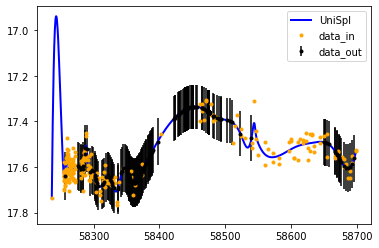

In [5]:
ztf_fake = ZTF_fake_LC('ZTF18aasszwr_format_r', 'FID807')
ztf_fake.generate_fake_LC(smoth_factor=0.3, shift=-20)
ztf_fake.visualise_intet_fit()


# Save figures and output file

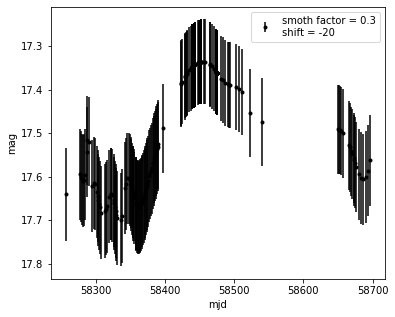

In [4]:
ztf_fake.plot_fake_LC()
ztf_fake.write_output()

# Generate fake Flat LC

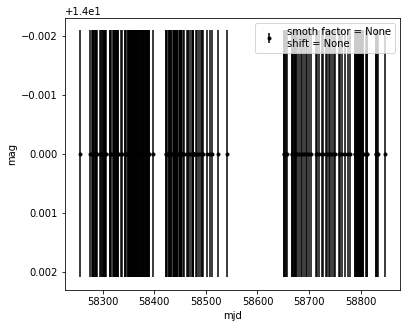

In [5]:
ztf_fake = ZTF_fake_LC('flat', 'FID807')
ztf_fake.generate_flat_fake_LC(mag_input=14. ,noise=0.0)
ztf_fake.plot_fake_LC()
ztf_fake.write_output()

# Feature files

In [ ]:
fakes = []
for file in glob.iglob('../data/fakes/output/FID695/*csv'):
    fake = ZTF_fake_LC.from_output(file)
    fake.extract_features()
    fakes.append(fake)
f = fakes[0]
f.features.keys()

ZTF18abaqxrt_format_r 0.08 -50.0 True
OGLE-LMC-CEP-0227_format_V 1 -200 True
Gaia16aye_2_format_r 1.0 -80.0 False
ZTF18aasszwr_format_r 0.3 -20 False
MACHO-6.6696.60_format_B 0.3 -600.0 True
OGLE-LMC-CEP-0227_format_I 1 -550 True
step 1 -90 False
ZTF18aaztjyd_format_r 1.0 -60 True
MACHO-6.6696.60_format_R 0.3 -430 True
flat_noise 0 0 True
Gaia16aye_format_r 0.05 0.0 False
ZTF18acskgwu_format_r 1 -0.0 False
ZTF18ablruzq_format_r 1 -50.0 False
ZTF18abhjrcf_format_r 4 -40 False
Gaia16aye_3_format_r 0.6 -20.0 False


In [12]:
write_features(fakes, names=f.features.keys(), output_folder='../data/fakes/', suffix='_deep_fake')